-----------
### CNN for pretraining weight classification like last week

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

# PyTorch TensorBoard support
# from torch.utils.tensorboard import SummaryWriter
# !pip install tensorboardX
# from tensorboardX import SummaryWriter
from datetime import datetime


transform = transforms.Compose(
        [transforms.Resize((32, 32)),
         transforms.Grayscale(num_output_channels=3),
         transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Create datasets for training & validation, download if necessary
# handwritten
# training_set = torchvision.datasets.USPS('./data', train=True, transform=transform, download=True)
# validation_set = torchvision.datasets.USPS('./data', train=False, transform=transform, download=True)
# training_set = torchvision.datasets.MNIST('./data', train=True, transform=transform, download=True)
# validation_set = torchvision.datasets.MNIST('./data', train=False, transform=transform, download=True)
# object recognition
training_set = torchvision.datasets.Caltech101('./data', transform=transform, download=True)
train_size = int(0.8 * len(training_set))
test_size = len(training_set) - train_size
training_set, validation_set = torch.utils.data.random_split(training_set, [train_size, test_size])


# Create data loaders for our datasets; shuffle for training, not for validation
training_loader = torch.utils.data.DataLoader(training_set, batch_size=16, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=16, shuffle=False)

# Class labels
# classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')

# Report split sizes
print('Training set has {} instances'.format(len(training_set)))
print('Validation set has {} instances'.format(len(validation_set)))

Files already downloaded and verified
Training set has 6941 instances
Validation set has 1736 instances


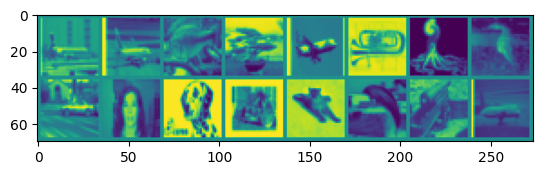

In [2]:
import matplotlib.pyplot as plt
import numpy as np

# Helper function for inline image display
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg)
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

dataiter = iter(training_loader)
images, labels = next(dataiter)

# Create a grid from the images and show them
img_grid = torchvision.utils.make_grid(images)
matplotlib_imshow(img_grid, one_channel=True)
# print('  '.join(classes[labels[j]] for j in range(16)))

In [3]:
def plot_graph(history):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_figwidth(10)
    fig.suptitle("Train vs Validation")
    ax1.plot(history["train_acc"], label="Train")
    ax1.plot(history["validate_acc"], label="Validation")
    ax1.legend()
    ax1.set_title("Accuracy")

    ax2.plot(history["train_loss"], label="Train")
    ax2.plot(history["validate_loss"], label="Validation")
    ax2.legend()
    ax2.set_title("Loss")
    fig.show()

In [4]:
import os
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
import time

#---Variable initialization---
torch.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#-----------------------------

In [7]:
# PyTorch models inherit from torch.nn.Module
#---CNN---
class InceptionBlock(nn.Module):
    def __init__(self, in_channels, c1, c2, c3, c4):
        super(InceptionBlock, self).__init__()

        self.branch_A = nn.Sequential(
            nn.Conv2d(in_channels, c1, kernel_size=1),
            nn.ReLU()
        )

        self.branch_B = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            nn.Conv2d(in_channels, c2, kernel_size=1),
            nn.ReLU()
        )

        self.branch_C_1 = nn.Sequential(
            nn.Conv2d(in_channels, c3[0], kernel_size=1),
            nn.ReLU(),
            nn.Conv2d(c3[0], c3[1], kernel_size=(1, 3), padding=(0,1)),
            nn.ReLU()
        )

        self.branch_C_2 = nn.Sequential(
            nn.Conv2d(in_channels, c3[0], kernel_size=1),
            nn.ReLU(),
            nn.Conv2d(c3[0], c3[1], kernel_size=(3, 1), padding=(1,0)),
            nn.ReLU()
        )

        self.branch_D_1 = nn.Sequential(
            nn.Conv2d(in_channels, c4[0], kernel_size=1),
            nn.ReLU(),
            nn.Conv2d(c4[0], c4[1], kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(c4[1], c4[2], kernel_size=(1, 3), padding=(0,1)),
            nn.ReLU()
        )

        self.branch_D_2 = nn.Sequential(
            nn.Conv2d(in_channels, c4[0], kernel_size=1),
            nn.ReLU(),
            nn.Conv2d(c4[0], c4[1], kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(c4[1], c4[2], kernel_size=(3, 1), padding=(1,0)),
            nn.ReLU()
        )

    def forward(self, x):
        Block_A = self.branch_A(x)
        Block_B = self.branch_B(x)
        Block_C_1 = self.branch_C_1(x)
        Block_C_2 = self.branch_C_2(x)
        Block_D_1 = self.branch_D_1(x)
        Block_D_2 = self.branch_D_2(x)

        # Concatenation of all feature maps of x passing in each branch
        x_out = torch.cat([Block_A, Block_B, Block_C_1, Block_C_2, Block_D_1, Block_D_2], 1)
        return x_out

class handwrittenmodel(nn.Module):
    def __init__(self):
        super(handwrittenmodel, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=10, kernel_size=4, stride=2, padding=1)  # 1x32x32 ---> 10x16x16
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  # 10x16x16 ---> 10x8x8
        # self.conv2 = nn.Conv2d(in_channels=10, out_channels=20, kernel_size=3, stride=1, padding=0) # 10x8x8 ---> 20x6x6
        self.inception = InceptionBlock(in_channels=10, c1=6, c2=6, c3=[3, 6], c4=[2, 4, 8])
        self.fc1 = nn.Linear(40 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 64)
        # self.fc3 = nn.Linear(32, 10)
        self.fc3 = nn.Linear(64, 101)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        # x = self.pool(F.relu(self.conv2(x)))
        x = self.inception(x)
        x = x.view(-1, 40 * 8 * 8)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Model init
model = handwrittenmodel().to(device)
summary(model, (3, 32, 32))

# Loss function
loss_fn = torch.nn.CrossEntropyLoss()
# Optimizers specified in the torch.optim package
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Initializing in a separate cell so we can easily add more epochs to the same run
# timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
# writer = SummaryWriter('runs/fashion_trainer_{}'.format(timestamp))
epoch_number = 0

EPOCHS_pretrained = 10
path_save_cp = './cp/'
best_vloss = 1_000_000.
training_logs = {"train_loss": [],  "train_acc": [], "validate_loss": [], "validate_acc": []}

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 16, 16]             490
         MaxPool2d-2             [-1, 10, 8, 8]               0
            Conv2d-3              [-1, 6, 8, 8]              66
              ReLU-4              [-1, 6, 8, 8]               0
         MaxPool2d-5             [-1, 10, 8, 8]               0
            Conv2d-6              [-1, 6, 8, 8]              66
              ReLU-7              [-1, 6, 8, 8]               0
            Conv2d-8              [-1, 3, 8, 8]              33
              ReLU-9              [-1, 3, 8, 8]               0
           Conv2d-10              [-1, 6, 8, 8]              60
             ReLU-11              [-1, 6, 8, 8]               0
           Conv2d-12              [-1, 3, 8, 8]              33
             ReLU-13              [-1, 3, 8, 8]               0
           Conv2d-14              [-1, 

#### Pre-training

In [8]:
t_0_accelerated = time.time()
for epoch in range(EPOCHS_pretrained):
    train_loss, train_correct = 0, 0
    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, data in enumerate(training_loader):
        # Every data instance is an input + label pair
        inputs, labels = data[0].to(device), data[1].to(device)

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model(inputs)

        # Compute the loss and its gradients
        loss = loss_fn(outputs, labels)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        train_loss += loss.item()
        train_correct += (outputs.argmax(1) == labels).float().sum().item()

    training_logs["train_loss"].append(train_loss / len(training_loader))
    training_logs["train_acc"].append(train_correct / len(training_loader.dataset))

    running_vloss = 0.0
    # Set the model to evaluation mode, disabling dropout and using population
    # statistics for batch normalization.
    model.eval()
    # Disable gradient computation and reduce memory consumption.
    valid_loss, valid_correct = 0, 0
    with torch.no_grad():
        for i, vdata in enumerate(validation_loader):
            vinputs, vlabels = vdata[0].to(device), vdata[1].to(device)
            voutputs = model(vinputs)
            vloss = loss_fn(voutputs, vlabels)
            valid_loss += loss_fn(voutputs, vlabels).item()
            valid_correct += (voutputs.argmax(1) == vlabels).float().sum().item()
        # save validation logs
        training_logs["validate_loss"].append(valid_loss / len(validation_loader))
        training_logs["validate_acc"].append(valid_correct / len(validation_loader.dataset))

    if epoch % 1 == 0:
        print(f"Epochs {epoch+1}".ljust(10),
            f"train loss {training_logs['train_loss'][-1]:.5f}",
            f"train acc {training_logs['train_acc'][-1]:.5f}",

            f"validate loss {training_logs['validate_loss'][-1]:.5f}",
            f"validate acc {training_logs['validate_acc'][-1]:.5f}",
            )
        print("-"*80)

    # Track best performance, and save the model's state
    if valid_loss < best_vloss:
        best_vloss = valid_loss
        # model_path = 'model_{}_{}'.format(timestamp, epoch_number)
        if not os.path.exists(path_save_cp): os.mkdir(path_save_cp)
        torch.save(model.state_dict(), path_save_cp+f'W5-1_best_pretrainedmodel_{EPOCHS_pretrained}ep.pth')

    epoch_number += 1

t_end_accelerated = time.time()-t_0_accelerated
print(f"Time consumption for accelerated CUDA training (device:{device}): {t_end_accelerated} sec")

Epochs 1   train loss 4.43141 train acc 0.08212 validate loss 4.20938 validate acc 0.08929
--------------------------------------------------------------------------------
Epochs 2   train loss 4.15572 train acc 0.12188 validate loss 4.03887 validate acc 0.15841
--------------------------------------------------------------------------------
Epochs 3   train loss 3.88897 train acc 0.18067 validate loss 3.71345 validate acc 0.22350
--------------------------------------------------------------------------------
Epochs 4   train loss 3.62378 train acc 0.23325 validate loss 3.51327 validate acc 0.26901
--------------------------------------------------------------------------------
Epochs 5   train loss 3.42651 train acc 0.27474 validate loss 3.31008 validate acc 0.29839
--------------------------------------------------------------------------------
Epochs 6   train loss 3.24332 train acc 0.31062 validate loss 3.18963 validate acc 0.31912
-------------------------------------------------

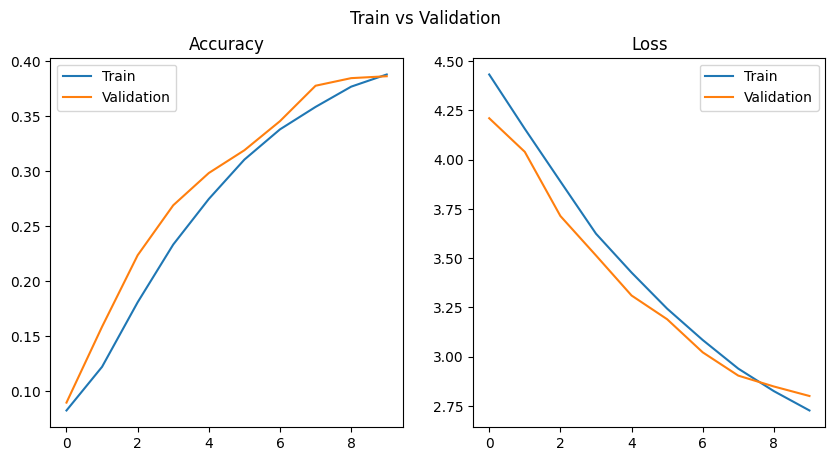

In [9]:
plot_graph(training_logs)

In [10]:
# Inference phase
PATH = path_save_cp+f'W5-1_best_pretrainedmodel_{EPOCHS_pretrained}ep.pth'
loaded_model = handwrittenmodel()
loaded_model.load_state_dict(torch.load(PATH))
acc_test = 0
test_loss = 0
loaded_model.to(device).eval()
for i, tdata in enumerate(validation_loader):
    tinputs, tlabels = tdata[0].to(device), tdata[1].to(device)
    toutputs = loaded_model(tinputs)
    loss = loss_fn(toutputs, tlabels)
    test_loss += loss

    _, preds_t = torch.max(toutputs, 1)
    acc_test += (preds_t == tlabels).float().mean().item()

accuracy_t = round(acc_test / float(len(validation_loader)), 4)
avg_tloss = test_loss / (i + 1)
print('[(pretraining || test loss: {}] [accuracy_test: {} %]'.format(avg_tloss, accuracy_t * 100))

<ipython-input-10-9cf8a88b9aa6>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model.load_state_dict(torch.load(PATH))


[(pretraining || test loss: 2.800149917602539] [accuracy_test: 38.59 %]


-------------
# Change classifier head to train another dataset

In [11]:
transform = transforms.Compose(
        [transforms.Resize((32, 32)),
         transforms.Grayscale(num_output_channels=3),
         transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
         ])

# Create datasets for training & validation, download if necessary
# handwritten
# training_set = torchvision.datasets.SVHN('./data', split='train', transform=transform, download=True)
# validation_set = torchvision.datasets.SVHN('./data', split='test', transform=transform, download=True)
# training_set = torchvision.datasets.QMNIST('./data', what='train', transform=transform, download=True)
# validation_set = torchvision.datasets.QMNIST('./data', what='test10k', transform=transform, download=True)
# object recognition
training_set = torchvision.datasets.STL10('./data', split='train', transform=transform, download=True)
validation_set = torchvision.datasets.STL10('./data', split='test', transform=transform, download=True)

# Create data loaders for our datasets; shuffle for training, not for validation
training_loader = torch.utils.data.DataLoader(training_set, batch_size=16, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=16, shuffle=False)

# Class labels
# classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')

# Report split sizes
print('Training set has {} instances'.format(len(training_set)))
print('Validation set has {} instances'.format(len(validation_set)))

100%|██████████| 2640397119/2640397119 [00:38<00:00, 69406932.21it/s]


Extracting ./data/stl10_binary.tar.gz to ./data
Files already downloaded and verified
Training set has 5000 instances
Validation set has 8000 instances


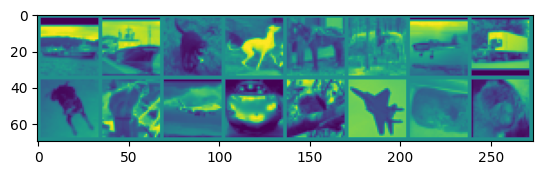

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# Helper function for inline image display
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg)
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

dataiter = iter(training_loader)
images, labels = next(dataiter)

# Create a grid from the images and show them
img_grid = torchvision.utils.make_grid(images)
matplotlib_imshow(img_grid, one_channel=True)
# print('  '.join(classes[labels[j]] for j in range(16)))

Change new head & some FC layers, fine-tune some layers and train our new head


```
# Optimization for ever layer at the same velocity and direction
optimizer = torch.optim.SGD(new_model_head.parameters(), lr=0.001, momentum=0.9)

                    ||||||||||
                    ||||||||||
                    ||||||||||
                    VVVVVVVVVV

# Optimization for some layers, out of them got freezing or fine-tuning with a few lr
lr = 1e-2
optimizer = torch.optim.SGD(
    [dict(params=new_model_head.conv1.parameters(), lr=0), # freeze them preferably
      dict(params=new_model_head.conv2.parameters(), lr=...), # relatively few adjusting lr to fine-tune
      dict(params=new_model_head.fc1.parameters(), lr=...), # relatively few adjusting lr to fine-tune
      dict(params=new_model_head.fc2.parameters()), # train from scratch for all new heads
      dict(params=new_model_head.fc3.parameters()), # train from scratch for all new heads
      ],
    lr=lr,  # learning rate for all layers if none of any setting individual
    momentum=0.9,
)
```



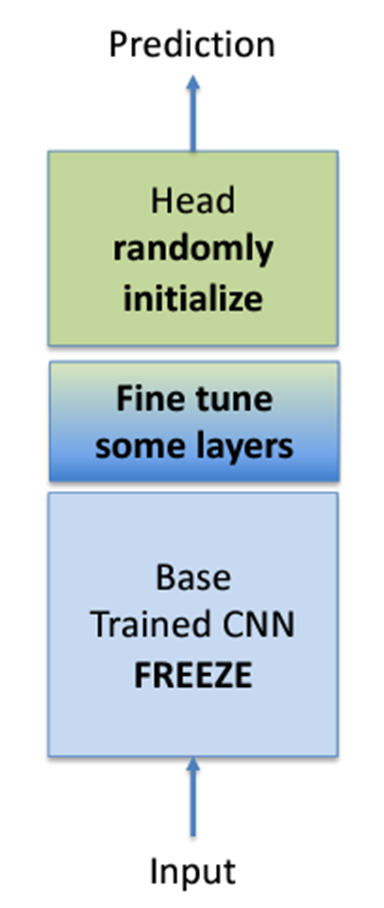

In [24]:
# Model init
new_model_head = handwrittenmodel().to(device)
#---load and replace new hidden layers---
load_pretrained = False
if load_pretrained:
  checkpoint = torch.load(path_save_cp+f'W5-1_best_pretrainedmodel_{EPOCHS_pretrained}ep.pth')
  new_model_head.load_state_dict(checkpoint, strict=False)
new_model_head.fc2 = nn.Linear(128, 32).to(device)
new_model_head.fc3 = nn.Linear(32, 10).to(device)
#---------------------------------------
summary(new_model_head, (3, 32, 32))

# Loss function
loss_fn = torch.nn.CrossEntropyLoss()

# Optimization for some layers, out of them got freezing or fine-tuning with a few lr
lr = 5e-3
optimizer = torch.optim.SGD(
    [dict(params=new_model_head.conv1.parameters(), lr=0), # 5e-4 = 0.0005 | freeze => lr = 0 | best at 1e-4
      dict(params=new_model_head.inception.parameters(), lr=1e-3),
      ],
    lr=lr,  # learning rate for all layers if none of any setting individual
    momentum=0.9,
)

epoch_number = 0

EPOCHS_finetune = 5
path_save_cp = './cp/'
best_vloss = 1_000_000.
training_logs = {"train_loss": [],  "train_acc": [], "validate_loss": [], "validate_acc": []}

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 16, 16]             490
         MaxPool2d-2             [-1, 10, 8, 8]               0
            Conv2d-3              [-1, 6, 8, 8]              66
              ReLU-4              [-1, 6, 8, 8]               0
         MaxPool2d-5             [-1, 10, 8, 8]               0
            Conv2d-6              [-1, 6, 8, 8]              66
              ReLU-7              [-1, 6, 8, 8]               0
            Conv2d-8              [-1, 3, 8, 8]              33
              ReLU-9              [-1, 3, 8, 8]               0
           Conv2d-10              [-1, 6, 8, 8]              60
             ReLU-11              [-1, 6, 8, 8]               0
           Conv2d-12              [-1, 3, 8, 8]              33
             ReLU-13              [-1, 3, 8, 8]               0
           Conv2d-14              [-1, 

In [ ]:
t_0_accelerated = time.time()
for epoch in range(EPOCHS_finetune):
    train_loss, train_correct = 0, 0
    # Make sure gradient tracking is on, and do a pass over the data
    new_model_head.train(True)
    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, data in enumerate(training_loader):
        # Every data instance is an input + label pair
        inputs, labels = data[0].to(device), data[1].to(device)

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = new_model_head(inputs)

        # Compute the loss and its gradients
        loss = loss_fn(outputs, labels)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        train_loss += loss.item()
        train_correct += (outputs.argmax(1) == labels).float().sum().item()

    training_logs["train_loss"].append(train_loss / len(training_loader))
    training_logs["train_acc"].append(train_correct / len(training_loader.dataset))

    running_vloss = 0.0
    # Set the model to evaluation mode, disabling dropout and using population
    # statistics for batch normalization.
    new_model_head.eval()
    # Disable gradient computation and reduce memory consumption.
    valid_loss, valid_correct = 0, 0
    with torch.no_grad():
        for i, vdata in enumerate(validation_loader):
            vinputs, vlabels = vdata[0].to(device), vdata[1].to(device)
            voutputs = new_model_head(vinputs)
            vloss = loss_fn(voutputs, vlabels)
            valid_loss += loss_fn(voutputs, vlabels).item()
            valid_correct += (voutputs.argmax(1) == vlabels).float().sum().item()
        # save validation logs
        training_logs["validate_loss"].append(valid_loss / len(validation_loader))
        training_logs["validate_acc"].append(valid_correct / len(validation_loader.dataset))

    if epoch % 1 == 0:
        print(f"Epochs {epoch+1}".ljust(10),
            f"train loss {training_logs['train_loss'][-1]:.5f}",
            f"train acc {training_logs['train_acc'][-1]:.5f}",

            f"validate loss {training_logs['validate_loss'][-1]:.5f}",
            f"validate acc {training_logs['validate_acc'][-1]:.5f}",
            )
        print("-"*80)

    # Track best performance, and save the model's state
    if valid_loss < best_vloss:
        best_vloss = valid_loss
        # model_path = 'model_{}_{}'.format(timestamp, epoch_number)
        if not os.path.exists(path_save_cp): os.mkdir(path_save_cp)
        torch.save(new_model_head.state_dict(), path_save_cp+f'W5-1_best_resumemodel_{EPOCHS_finetune}ep.pth')

    epoch_number += 1

t_end_accelerated = time.time()-t_0_accelerated
print(f"Time consumption for accelerated CUDA training (device:{device}): {t_end_accelerated} sec")

NameError: name 'time' is not defined

In [ ]:
plot_graph(training_logs)

In [ ]:
# Inference phase
PATH = path_save_cp+f'W5-1_best_resumemodel_{EPOCHS_finetune}ep.pth'
loaded_resume_model = handwrittenmodel().to(device)
loaded_resume_model.fc2 = nn.Linear(128, 32).to(device)
loaded_resume_model.fc3 = nn.Linear(32, 10).to(device)
if torch.cuda.is_available():
  loaded_resume_model.load_state_dict(torch.load(PATH))
else:
  loaded_resume_model.load_state_dict(torch.load(PATH, map_location=torch.device('cpu')))
acc_test = 0
test_loss = 0
loaded_resume_model.to(device).eval()
stored_lbs = torch.empty(0, dtype=torch.float32).to(device)
stored_preds = torch.empty(0, dtype=torch.float32).to(device)
for i, tdata in enumerate(validation_loader):
    tinputs, tlabels = tdata[0].to(device), tdata[1].to(device)
    toutputs = loaded_resume_model(tinputs)
    loss = loss_fn(toutputs, tlabels)
    test_loss += loss
    # Argmax one-hot pred to class vector
    _, preds_t = torch.max(toutputs, 1)
    acc_test += (preds_t == tlabels).float().mean().item()
    # store vec
    stored_lbs = torch.cat((stored_lbs, tlabels), 0)
    stored_preds = torch.cat((stored_preds, preds_t), 0)

accuracy_t = round(acc_test / float(len(validation_loader)), 4)
avg_tloss = test_loss / (i + 1)
print('[(resume training || test loss: {}] [accuracy_test: {} %]'.format(avg_tloss, accuracy_t * 100))

# Quantitative and Visualization Measures
- t-SNE (New)
- NMI/RI score (New)
- Precision, Recall, F1-score, Confusion Matrix

In [ ]:
# https://github.com/fyse-nassar/Malware-Family-Classification/blob/master/Malware%20Opcode%20Ngrams%20Generator.ipynb
# https://scikit-learn.org/0.18/auto_examples/model_selection/plot_confusion_matrix.html

import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    Normalization can be applied by setting `normalize=True`.
    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    #plt.xticks(tick_marks, classes, rotation=45)    #office-31
    plt.xticks(tick_marks, classes, rotation=20, fontsize=12)    #office-home
    plt.yticks(tick_marks, classes, fontsize=12)

    if normalize==True:
        cm = cm.astype('float') / (cm.sum(axis=1)[:, np.newaxis]+1)
        #print("Normalized confusion matrix")
    #else:
        #print('Confusion matrix, without normalization')

    # print(cm)

    formated = '.2f' if normalize==True else 'd'
    #---manual---
    thresh = cm.max() / 2.
    #thresh > 0.5
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], formated),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    #---sns---
    #df_cm = pd.DataFrame(cm, classes, classes)
    #sns.heatmap(df_cm, annot=True, fmt=formated, cmap=cmap)

    plt.gcf().set_size_inches(8, 6)
    plt.ylabel('Ground Truth')
    plt.xlabel('Prediction')
    plt.margins(2,2)
    plt.tight_layout()



"""
  Args: Collect feature
  Ref: https://github.com/zhjscut/Bridging_UDA_SSL/blob/e0be6742f1203bb983261e3e1e57d34e1e03299d/common/utils/analysis/__init__.py#L7
"""
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import tqdm
import os.path as osp


def collect_feature(data_loader: DataLoader, feature_extractor: nn.Module,
                                   device: torch.device, max_num_features=None) -> torch.Tensor:
    """
    Fetch data from `data_loader`, and then use `feature_extractor` to collect features
    Args:
        data_loader (torch.utils.data.DataLoader): Data loader.
        feature_extractor (torch.nn.Module): A feature extractor.
        device (torch.device)
        max_num_features (int): The max number of features to return
    Returns:
        Features in shape (min(len(data_loader), max_num_features), :math:`|\mathcal{F}|`).
    """
    feature_extractor.eval()
    all_features = []
    all_labels = []
    with torch.no_grad():
        for i, (images, target) in enumerate(tqdm.tqdm(data_loader)):
            images = images.to(device)
            features = feature_extractor(images)
            if isinstance(features, tuple):
                # Check if it's a tuple (common when using certain pre-trained models)
                # You may want to select the feature tensor you need from the tuple
                # For example, if the feature tensor is the first element of the tuple:
                feature_tensor = features[0]
                feature_tensor = feature_tensor.to(device)  # Move the tensor to CPU
            else:
                feature_tensor = features.to(device)  # Move the tensor to CPU

            all_features.append(feature_tensor)
            all_labels.append(target)

    return torch.cat(all_features, dim=0),\
        torch.cat(all_labels, dim=0) # Concatenate the list of feature tensors

    #        all_features.append(features)
    #        if max_num_features is not None and i >= max_num_features:
    #            break
    #return torch.cat(all_features, dim=0)


# ref https://github.com/zhjscut/Bridging_UDA_SSL/blob/e0be6742f1203bb983261e3e1e57d34e1e03299d/common/utils/analysis/__init__.py#L7
import torch
import matplotlib

matplotlib.use('Agg')
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as col


def visualize(source_feature: torch.Tensor, target_feature: torch.Tensor,
              filename: str, source_color='r', target_color='b'):
    """
    Visualize features from different domains using t-SNE.
    Args:
        source_feature (tensor): features from source domain in shape :math:`(minibatch, F)`
        target_feature (tensor): features from target domain in shape :math:`(minibatch, F)`
        filename (str): the file name to save t-SNE
        source_color (str): the color of the source features. Default: 'r'
        target_color (str): the color of the target features. Default: 'b'
    """
    source_feature = source_feature.cpu().numpy()
    target_feature = target_feature.cpu().numpy()
    features = np.concatenate([source_feature, target_feature], axis=0)

    # map features to 2-d using TSNE
    X_tsne = TSNE(n_components=2, random_state=33).fit_transform(features)

    # domain labels, 1 represents source while 0 represents target
    domains = np.concatenate((np.ones(len(source_feature)), np.zeros(len(target_feature))))

    # visualize using matplotlib
    plt.figure(figsize=(10, 10))
    plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=domains, cmap=col.ListedColormap([source_color, target_color]), s=20)  #default: s=2
    plt.savefig(filename)

import torch
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib.colors as col

"""
  Arg: t-SNE for class clustering visualization
"""

def visualize_class_n_domain(source_feature: torch.Tensor, target_feature: torch.Tensor, source_labels: torch.Tensor, target_labels: torch.Tensor, filename: str, source_color='r', target_color='b'):
    """
    Visualize features from different domains using t-SNE.
    Args:
        source_feature (tensor): features from source domain in shape :math:`(minibatch, F)`
        target_feature (tensor): features from target domain in shape :math:`(minibatch, F)`
        source_labels (tensor): class labels for source domain features
        target_labels (tensor): class labels for target domain features
        filename (str): the file name to save t-SNE
        source_color (str): the color of the source features. Default: 'r'
        target_color (str): the color of the target features. Default: 'b'
    """
    source_feature = source_feature.cpu().numpy()
    target_feature = target_feature.cpu().numpy()
    source_labels = source_labels.cpu().numpy()
    target_labels = target_labels.cpu().numpy()

    # Combine features and labels
    features = np.concatenate([source_feature, target_feature], axis=0)
    labels = np.concatenate([source_labels, target_labels], axis=0)
    domains = np.concatenate((np.ones(len(source_feature)), np.zeros(len(target_feature))))

    # Map features to 2-D using t-SNE
    X_tsne = TSNE(n_components=2, random_state=33).fit_transform(features)

    # Visualize using matplotlib
    plt.figure(figsize=(10, 10))

    # Get unique class labels
    unique_labels = np.unique(labels)

    # Create a color map for classes
    #cmap = plt.get_cmap('tab20', len(unique_labels))
    cmap_s = plt.get_cmap('nipy_spectral', len(unique_labels))
    cmap_r = plt.get_cmap('gist_rainbow', len(unique_labels))

    # Plot data points for each class and domain
    for label in unique_labels:
        for domain in [0, 1]:
            mask = (labels == label) & (domains == domain)
            plt.scatter(X_tsne[mask, 0], X_tsne[mask, 1], c=cmap_s(label), s=10,
                        #label=f"Class {label}, Domain {domain}",
                        )

    plt.legend()
    plt.savefig(filename)

# Example usage
# visualize(source_feature, target_feature, source_labels, target_labels, 'tsne_plot.png')





from torch.utils.data import TensorDataset
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.optim import SGD
# from .meter import AverageMeter
# from ..metric import binary_accuracy

"""
  Args: A-distance computation
  Ref: https://github.com/zhjscut/Bridging_UDA_SSL/blob/e0be6742f1203bb983261e3e1e57d34e1e03299d/common/utils/analysis/a_distance.py
"""

def binary_accuracy(output: torch.Tensor, target: torch.Tensor) -> float:
    """Computes the accuracy for binary classification"""
    with torch.no_grad():
        batch_size = target.size(0)
        pred = (output >= 0.5).float().t().view(-1)
        correct = pred.eq(target.view(-1)).float().sum()
        correct.mul_(100. / batch_size)
        return correct

class ANet(nn.Module):
    def __init__(self, in_feature):
        super(ANet, self).__init__()
        self.layer = nn.Linear(in_feature, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.layer(x)
        x = self.sigmoid(x)
        return x


def calculate(source_feature: torch.Tensor, target_feature: torch.Tensor,
              device, progress=True, training_epochs=10):
    """
    Calculate the :math:`\mathcal{A}`-distance, which is a measure for distribution discrepancy.
    The definition is :math:`dist_\mathcal{A} = 2 (1-2\epsilon)`, where :math:`\epsilon` is the
    test error of a classifier trained to discriminate the source from the target.
    Args:
        source_feature (tensor): features from source domain in shape :math:`(minibatch, F)`
        target_feature (tensor): features from target domain in shape :math:`(minibatch, F)`
        device (torch.device)
        progress (bool): if True, displays a the progress of training A-Net
        training_epochs (int): the number of epochs when training the classifier
    Returns:
        :math:`\mathcal{A}`-distance
    """
    source_label = torch.ones((source_feature.shape[0], 1))
    target_label = torch.zeros((target_feature.shape[0], 1))
    feature = torch.cat([source_feature, target_feature], dim=0)
    label = torch.cat([source_label, target_label], dim=0)

    dataset = TensorDataset(feature, label)
    length = len(dataset)
    train_size = int(0.8 * length)
    val_size = length - train_size

    # Specify a random generator for CUDA
    generator = torch.Generator(device=device)

    train_set, val_set = torch.utils.data.random_split(dataset, [train_size, val_size], generator)
    train_loader = DataLoader(train_set, batch_size=2, shuffle=True, generator=generator)
    val_loader = DataLoader(val_set, batch_size=8, shuffle=False, generator=generator)

    anet = ANet(feature.shape[1]).to(device)
    optimizer = SGD(anet.parameters(), lr=0.01)
    a_distance = 2.0
    for epoch in range(training_epochs):
        anet.train()
        for (x, label) in train_loader:
            x = x.to(device)
            label = label.to(device)
            anet.zero_grad()
            y = anet(x)
            loss = F.binary_cross_entropy(y, label)
            loss.backward()
            optimizer.step()

        anet.eval()
        meter = AverageMeter("accuracy", ":4.2f")
        with torch.no_grad():
            for (x, label) in val_loader:
                x = x.to(device)
                label = label.to(device)
                y = anet(x)
                acc = binary_accuracy(y, label)
                meter.update(acc, x.shape[0])
        error = 1 - meter.avg / 100
        a_distance = 2 * (1 - 2 * error)
        if progress:
            print("epoch {} accuracy: {} A-dist: {}".format(epoch, meter.avg, a_distance))

    return a_distance



###########################################################################################










source_feature, s_labels = collect_feature(validation_loader, loaded_resume_model, device)
# target_feature, t_labels = collect_feature(target_dl, feature_extractor, device)

# --- plot t-SNE
if not os.path.exists('./output/'): os.mkdir('./output/')
tSNE_filename = osp.join('./output/', 'W5-1_tSNE.png')
visualize_class_n_domain(source_feature, source_feature, s_labels, s_labels, tSNE_filename)    # single-domain multi-class rep
# visualize_class_n_domain(source_feature, target_feature, s_labels, t_labels, tSNE_filename)    # two-domain multi-class rep
print("Saving t-SNE to", tSNE_filename)


# --- Calculate A-distance, which is a measure for distribution discrepancy
# A_distance = a_distance.calculate(source_feature, target_feature, device)
# print("A-distance =", A_distance)



# --- Confusion matrix, F1-score, precision, recall, NMI/RI scores
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, normalized_mutual_info_score, adjusted_rand_score, f1_score
# # Class labels
pos_labels = np.arange(10)
lb_classes = ('0', '1', '2', '3', '4', '5', '6' ,'7', '8', '9')

lb = stored_lbs.cpu()
prd = stored_preds.cpu()
#---confusion matrix
cm_target = confusion_matrix(y_true=lb,
                            y_pred=prd,
                            labels=pos_labels,
                            normalize='true',
                            )
plt.figure()
plt.rcParams.update({'font.size': 10, 'figure.figsize': (2,2)})
plot_confusion_matrix(cm_target,
                        classes=lb_classes,
                        normalize=True,
                        title='Conf. Mat. w.r.t. CIFAR-10 ds',
                        cmap=plt.cm.binary #Blues_r
                        )    #Blues_r = off-white diagonal
#---F1-score/Precision/Recall scores
print("Precision/Recall/F-beta score:", precision_recall_fscore_support(lb, prd, average='weighted', zero_division=0,
                                          beta=1.0)) #labels=label_classes))
#---Normalized Mutual Information (NMI) score
nmi_score = normalized_mutual_info_score(labels_true=lb,
                                        labels_pred=prd,
                                        average_method='arithmetic',
                                        )
#---Rand Index (RI) score
ri_score = adjusted_rand_score(labels_true=lb,
                                labels_pred=prd,
                                )
print(f"NMI score: {nmi_score}, RI score: {ri_score}")

-----
# In-class exercise
ลองกำหนดโมเดลโดยเปลี่ยนหัวคัดแยกประเภท (classifier head) เพื่อใช้กับ SVHN ทำการ fine-tune layers (ปรับ lr ให้ดีที่สุดเท่าที่ทำได้) เปรียบเทียบผลความแม่นยำ (Accuracy) จาก 5 ข้อย่อยด้านล่าง
 \
กำหนดให้โมเดลเรียนรู้แค่อย่างละ 2 epoches max ด้วย SVHN dataset และใช้ learning rate ต่ำกว่า 1e-3 ในแต่ละ fine-tune layer

```
# เลเยอร์ fc ใหม่ (New classifier head)
conv1 ---> conv2 ---> flattening ---> fc1 ---> fc2 ---> fc3
 ...        ...          20*3*3        128      32      10
```

1. freeze ทุกเลเยอร์/fine-tune fc1
```
conv1 ---> conv2 ---> flattening ---> fc1 ---> fc2 ---> fc3
freeze     freeze         ...        freeze    freeze    hot
```

2. freeze ทุกเลเยอร์/fine-tune fc2-fc1
```
conv1 ---> conv2 ---> flattening ---> fc1 ---> fc2 ---> fc3
freeze     freeze         ...        freeze     hot      hot
```

3. freeze encoder/fine-tune classifier head
```
conv1 ---> conv2 ---> flattening ---> fc1 ---> fc2 ---> fc3
freeze     freeze         ...         hot      hot      hot
```

4. freeze แค่ conv1
```
conv1 ---> conv2 ---> flattening ---> fc1 ---> fc2 ---> fc3
freeze      hot          ...          hot      hot      hot
```

4. fine-tune ทุกเลเยอร์
```
conv1 ---> conv2 ---> flattening ---> fc1 ---> fc2 ---> fc3
  hot       hot          ...          hot      hot      hot
```


--------------------
# Homework
- ออกแบบโมเดลแบบ โดยใช้ InceptionV3 block (ภาพขวา) กับฟีเจอร์ ที่ออกจาก conv-pool ชั้นแรก
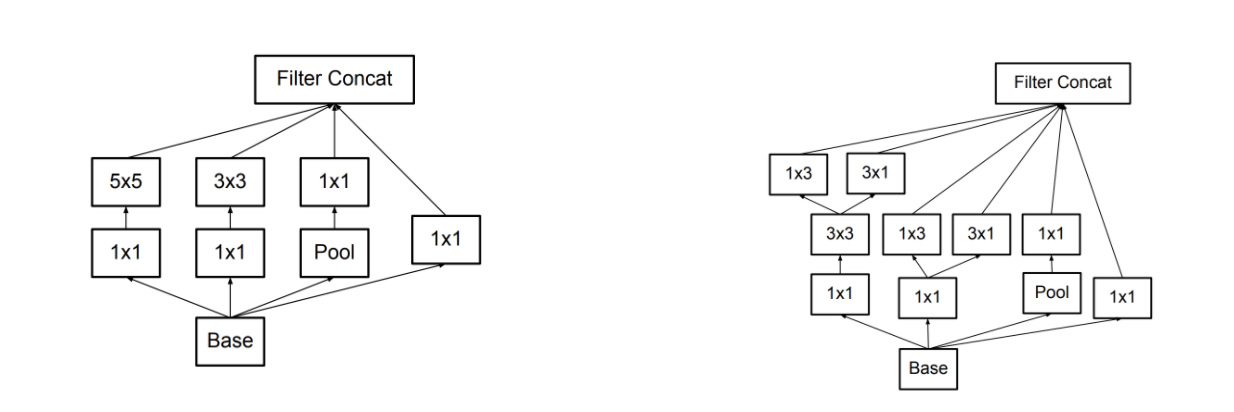

- [source dataset = Caltech101] ฝึกฝน pretained model บนข้อมูล source จำนวนวนรอบมากกว่าหรือเท่ากับ 10 รอบ (>= 10 epoches)
- [target dataset = STL10] จำนวนวนซ้ำที่ 5 รอบ (5 epoches) สำหรับการฝึกฝนบนข้อมูล target

\
1.) [Pretraining part] เทียบโมเดลที่ฝึกฝน Caltech101 ด้วย InceptionV1 กับ InceptionV3 ทั้งด้านประสิทธิภาพและทรัพยากรที่ใช้\
2.) [Resume training] ฝึกฝน STL10 ที่ใช้ pre-trained weight จาก Caltech101 เรียนในทุกเลเยอร์ (learning rate เดียวกันทุกเลเยอร์) คล้ายกับการบ้าน W4-2\
3.) [Fine-tune training] ฝึกฝน STL10 ที่ใช้ pre-trained weight จาก Caltech101 แบบ fine-tune weight บางเลเยอร์ (learning rate ค่อยปรับไล่ระดับ)\
4.)  เปรีบเทียบผลลัพธ์เชิงปริมาณและการแสดงผลทั้ง Quantitative (Accuracy, loss, precision, recall, F1-score, NMI/RI scores, resource usage) and visualization results (t-SNE, plot) จากข้อ 1 และ 2